# Regionalizing Prague Regions

**Regionalization** is a clustering technique that groups spatial items having areal representations into homogenous continuous regions. A reasonable assumption in cities is that the contiguous subregions can be regionalized into spatial communities (clusters). Such a task can assist providers in various complex problems, such as picking warehouse locations, producing effective geo-marketing campaigns, and producing fair geo-based policies. In this final project, we aim to investigate methods that take into account the place of subregions and use spatial information to create spatial clusters. 

To better understand the task, consider the following map of Prague:

![invalidRegionalization.png](mapPrague.png)

A *valid* regionalization output can be seen bellow. Note that the three clusters are contiguous. It means that if a subregion $x_i$ belongs to the region $R_k$, at least one subregion $x_j \in R_k$ shares a border with x_i.

![invalidRegionalization.png](validRegionalization.png)

 However, the partition bellow is not a valid regionalization. The reason is that one can find a subregion of $R_3$ that does not connect to any subregion of $R_3$.

![invalidRegionalization.png](invalidRegionalization.png)

In [14]:
import sys
print(sys.version)
sys.executable


3.12.0 | packaged by conda-forge | (main, Oct  3 2023, 08:36:57) [Clang 15.0.7 ]


'/Users/blgd/miniconda3/envs/ml1/bin/python'

# Final Project (16 points)

The final project is a group project. The main task is to cluster the Prague map into $k$ regions respecting regionalization constraints. Your group needs to:

* <b>Develop a **new** learning algorithm for regionalizing maps.</b>
* <b>Run your algorithm and compare it with **at least** one baseline (you must research at least one baseline).</b>
* <b>Choose the *best* value of $k$ under some assumption (e.g. elbow rule)</b>
* <b>Find anomalous subregions inside the clusters.</b>
* Make a report that describes the method and engineering decisions (max three pages).
* Produce a blog post that explains your method for a broad audience (you do not need to publish it).
* You must present your solution in the form of a business presentation to sell your solution would be the best way to regionalize Prague.

Obs.: A cluster must contain at least $10$ subregions

Note that I am not constraining the project. For example, I am not defining the metrics you should use. However, I expect the justification for project decisions in both the report and the presentation.

In [15]:
import numpy as np
import math
import geopandas
import pandas as pd

In [16]:
#Open Geographic Information
gdf = geopandas.read_file("MAP_MESTSKECASTI_P.shp")
gdf['ID'] = gdf['ID'].astype(int)
gdf.head(5)

,DAT_VZNIK,DAT_ZMENA,PLOCHA,ID,KOD_MC,NAZEV_MC,KOD_MO,KOD_SO,TID_TMMEST,POSKYT,ID_POSKYT,STAV_ZMENA,NAZEV_1,Shape_Leng,Shape_Area,geometry
0,2018-11-06,2021-12-07,10183715.62,25,547310,Praha-Čakovice,94,221,25,HMP-IPR,43,U,Čakovice,18510.070836,1.018372e+07,"POLYGON ((-733164.100 -1037426.870, -733137.03..."
1,2017-11-10,2022-04-05,13529637.10,9,547361,Praha 14,94,141,9,HMP-IPR,43,U,Praha 14,21694.540692,1.352964e+07,"POLYGON ((-732843.230 -1045666.050, -732873.05..."
2,2018-10-09,2022-08-03,23317908.20,4,547107,Praha 12,43,124,4,HMP-IPR,43,U,Praha 12,28249.410338,2.331791e+07,"POLYGON ((-741841.950 -1052678.550, -741838.85..."
3,2018-11-06,2022-02-16,3253142.38,52,547174,Praha 17,60,213,52,HMP-IPR,43,U,Praha 17,7936.181054,3.253142e+06,"POLYGON ((-752038.720 -1042852.140, -752039.50..."
4,2016-04-22,2021-11-16,7379375.19,23,547298,Praha-Ďáblice,86,86,23,HMP-IPR,43,U,Ďáblice,14957.952940,7.379375e+06,"POLYGON ((-739567.300 -1037894.610, -739567.00..."


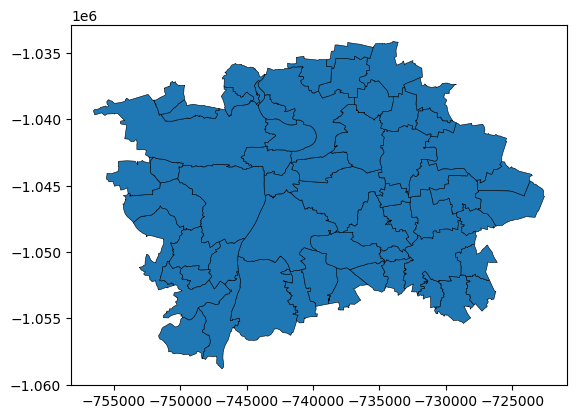

In [17]:
#Printing a map
gdf['cluster']=np.zeros(gdf['ID'].shape[0])
regions = gdf.plot(column='cluster', linewidth=0.4, edgecolor='black', legend=False, categorical=True)

In [18]:
def connectionGraph(gdf):
    graph = {}
    for index, row in gdf.iterrows():
        neighbors = gdf[~gdf.geometry.disjoint(row.geometry)].ID.tolist()
        neighbors = [n_id for n_id in neighbors if row.ID != n_id]
        graph[row.ID] = neighbors
    return graph

graph = connectionGraph(gdf)
print(graph)

{25: [23, 35, 42, 26, 40], 9: [6, 10, 7, 40, 53, 41, 32], 4: [19, 14, 3, 39], 52: [1, 11, 2, 17], 23: [25, 46, 35, 42, 5], 6: [9, 38, 10, 30, 15, 12, 3, 53], 45: [34, 29, 15], 46: [23, 35, 5], 57: [34, 15, 12, 49, 8], 38: [6, 10, 30, 5], 13: [11, 22, 16], 43: [1, 30, 2, 24, 5], 1: [52, 43, 44, 2, 50, 24, 48, 51, 56, 5, 17], 10: [9, 6, 38, 42, 40, 5], 44: [1, 56, 5], 20: [12, 53, 27, 8], 34: [45, 57, 15, 49], 19: [4, 29, 3], 35: [25, 23, 46], 30: [6, 38, 43, 3, 2, 5], 11: [52, 13, 22, 2, 17], 29: [45, 19, 15, 3], 22: [13, 11, 2, 55, 39, 16], 54: [18, 8], 42: [25, 23, 10, 40, 5], 18: [54, 31, 47, 8], 15: [6, 45, 57, 34, 29, 12, 3], 14: [4, 39, 28, 16], 12: [6, 57, 20, 15, 53, 8], 3: [4, 6, 19, 30, 29, 15, 2, 39], 2: [52, 43, 1, 30, 11, 22, 3, 39], 7: [9, 41, 32, 21, 37], 49: [57, 34, 8], 50: [1, 24, 5], 24: [43, 1, 50, 5], 26: [25, 40, 32], 55: [22, 39, 16], 48: [1, 51], 40: [25, 9, 10, 42, 26, 32], 33: [27, 8, 36, 37], 31: [18, 47], 53: [9, 6, 20, 12, 27, 41], 27: [20, 33, 53, 41, 8, 37

<Axes: >

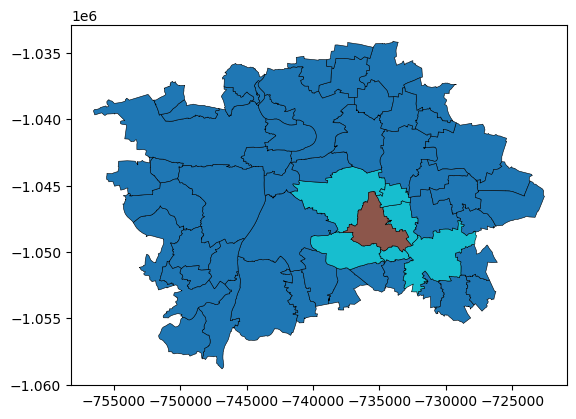

In [19]:
gdf['cluster']=np.zeros(gdf['ID'].shape[0])
subreg = 12
gdf.loc[gdf['ID']==subreg,'cluster'] = 1
for neighbor in graph[subreg]:
    gdf.loc[gdf['ID']==neighbor,'cluster'] = 2
    
gdf.plot(column='cluster', linewidth=0.4, edgecolor='black', legend=False, categorical=True)

The regionalization must be done according to the demographic values represented by the following dataframe

In [20]:
#Printing a map
def print_map(clusters):
    gdf_copy = gdf.set_index("ID")
    gdf_copy.sort_index(inplace=True)
    
    gdf_copy['cluster']= clusters
    regions = gdf_copy.plot(column='cluster', linewidth=0.4, edgecolor='black', legend=False, categorical=True)


In [21]:
df=pd.read_csv('pragueFeatures.csv')
print(df.head(6))
df1 = df.set_index("ID")
df2 = df1.sort_index()
print(df1)


   ID  Feature_1  Feature_2  Feature_3  Feature_4
0  25  -0.242001  -0.199829  -2.444677   0.558649
1   9   2.058356  -0.550588  -1.992667  -0.287513
2   4   0.022728  -0.399645  -2.061011   0.429079
3  52   2.237722   0.858906   0.293994  -1.890483
4  23   1.121568  -0.433501  -2.399417  -0.102562
5   6   0.039704   0.240612  -2.736600   2.017571
    Feature_1  Feature_2  Feature_3  Feature_4
ID                                            
25  -0.242001  -0.199829  -2.444677   0.558649
9    2.058356  -0.550588  -1.992667  -0.287513
4    0.022728  -0.399645  -2.061011   0.429079
52   2.237722   0.858906   0.293994  -1.890483
23   1.121568  -0.433501  -2.399417  -0.102562
6    0.039704   0.240612  -2.736600   2.017571
45   0.180722   1.164965  -1.866302   1.595274
46   2.062138   0.050798   0.206467  -1.705487
57   0.009476  -0.677654  -2.564272   2.329335
38   2.012007   0.260663   0.084743  -1.384562
13   0.361847  -0.982718  -2.051687   0.796554
43   2.073870   0.190115  -0.729359  -1

In [22]:
import matplotlib.pyplot as plt
from collections import deque 

import random

## Modify KMeans to check neighbors points instead of all points

In [34]:
class KMeansWithNeighbors:
    def __init__(self, n_clusters, neighbors=[], max_iters=100, n_best = 10, random_seed=None, init_centroids = []):
        self.neighbors = neighbors
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.look_for_n_best = n_best
        self.centroids = []
        self.labels = None
        self.inertia = None
        self.random_seed = random_seed
        self.init_centroids = init_centroids
        self._labels_map = {}

    def fit(self, df):
        df = df.copy()
        # Set random seed if provided
        if self.random_seed is not None:
            np.random.seed(self.random_seed)

        m = df.shape[0]
        n = df.shape[1]
        # Convert data to a numpy array
        if isinstance(df, pd.DataFrame):
            data = df.values
        # Each centroid or group will have some possible neighbors to explore(in terms of map)
        allowed_neighbors = {}
       
        random_instances = np.random.choice(np.arange(1, 58), size=self.n_clusters, replace=False)
        # Randomly initialize centroids
        if len(self.init_centroids) != 0:
            random_instances = self.init_centroids     
        for i in range(self.n_clusters):
            self.centroids.append(data[random_instances[i]-1])
        self.centroids = np.array(self.centroids)
        
        # Add in allowed neighbors, in the initial run, it's only neigbors of the current instances
        for i in range(self.n_clusters):
            allowed_neighbors[i] = set(self.neighbors[random_instances[i]])
        # self.centroids = data[np.random.choice(data.shape[0], self.n_clusters, replace=False)]
        
        self.labels = np.ones(m, dtype=int) * (-1)
        previous_labels = self.labels 
        # Add initial points to the centroids
        for i in range(self.n_clusters):
            self._labels_map[i] = set()
            self._labels_map[i].add(random_instances[i])
            self.labels[random_instances[i]-1] = i
        for iter in range(self.max_iters):
            previous_labels = self.labels
            
        # for each of the centroid's neighbors, assign the closest one
            for i in range(self.n_clusters):
                allowed_neighbors[i] = self.find_possible_neighbors(i)
                best_to_worst = self.sort_to_worst_neigh(df, i , allowed_neighbors[i])
                # how many chances one will get. If the current best is occupied and can't beat them, look for more neighbors to conquer
                number_of_chances = len(best_to_worst)
                    
                for ith_best in range(number_of_chances):  
                    best_neigh_id = int(best_to_worst[ith_best])
                    # assign the label to that best found neighbor
                    
                    # if it's not assigned yet
                    if self.labels[best_neigh_id-1] == -1:
                        
                        # tag current instance to the centroid
                        # print(f"{i} centroid found unoccupied territory {best_neigh_id}")
                        self.labels[best_neigh_id-1] = i
                        self._labels_map[i].add(best_neigh_id)
                        
                        # enlarge number of neighbors, the current one is already label thus, delete the current one and add current one's neighbors
                        break
                    else:
                        # find the label the current instance belongs to
                        alien_group_id = self.labels[best_neigh_id-1]
                        if alien_group_id == i:
                            continue
                            
                        # find to whom, the point is closest to
                        contestor_distance = self.distance(self.centroids[alien_group_id], data[best_neigh_id-1])
                        current_distance = self.distance(self.centroids[i], data[best_neigh_id-1])
                        # if the contestor grouping is better
                        if contestor_distance < current_distance:
                            continue
                        # make that label ours 
                        if len(self._labels_map[alien_group_id]) <= 10:
                            continue
                        # if len(self._labels_map[alien_group_id]) <= 2:
                        #     continue
                        self.labels[best_neigh_id-1] = i
                        self._labels_map[i].add(best_neigh_id)
                        
                        # remove it from their labels_map
                        self._labels_map[alien_group_id].remove(best_neigh_id)
                        # propogate a cut
                        self.cluster_detector_and_remove_small(alien_group_id)
                        break
                
                # update centroid
                self.update_centroid(data)
            # if iter < 20 and iter > 10:
            #     clusters = np.array(self.labels, dtype=int)
            #     print_map(clusters)
            # print(self._labels_map)
            # convergence test
            converged = True
            for label in self.labels:
                if label == -1:
                    converged = False
                    break
            for i in range(len(self.labels)):
                if self.labels[i] != previous_labels[i]:
                    converged = False
                    break
            if converged:
                break
        self.inertia = self._compute_inertia(data)

    def cluster_detector_and_remove_small(self, group_id):
        instances_in_group = set()
        for index,label in enumerate(self.labels):
            if label == group_id:
                instances_in_group.add(index+1)
                
        def bfs(start_index):
            visited = set()
            queue = deque([start_index])
            connected_component = set()
            
            while queue:
                current_index = queue.popleft()
                visited.add(current_index)
                connected_component.add(current_index)
                
                # Find neighbors of the current index
                neighbors = self.neighbors[current_index]  
                
                # Add unvisited neighbors to the queue
                for neighbor in neighbors:
                    if neighbor not in visited and neighbor in instances_in_group:
                        queue.append(neighbor)
                        visited.add(neighbor)
                        connected_component.add(neighbor)
    
            return connected_component
    
        connected_components = []
        unvisited = instances_in_group.copy()
        
        # Iterate through instances in the group and perform BFS to find connected components
        while unvisited:
            current_instance = unvisited.pop()
            connected_component = bfs(current_instance)
            connected_components.append(connected_component)
            unvisited -= connected_component
        
        if(len(connected_components) <= 1):
            return 
        # if there's more than 1 component or cluster, we keep the biggest one and delete smaller
        index_of_max_set = max(enumerate(connected_components), key=lambda x: len(x[1]))[0]
        connected_components.pop(index_of_max_set)

        for cluster in connected_components:
            for instance_id in cluster:
                self.labels[instance_id-1] = -1
                self._labels_map[group_id].remove(instance_id)


    def find_possible_neighbors(self, centroid_id):
        instance_contained = self._labels_map[centroid_id]
        possible_neighs = []
        for instance_id in instance_contained:
            for neigh_id in self.neighbors[instance_id]:
                if self.labels[neigh_id-1] == centroid_id:
                    continue
                possible_neighs.append(neigh_id)
        return set(possible_neighs)
    
    def sort_to_worst_neigh(self, df, centroid_id, possible_neighbors):
        neighs = list(possible_neighbors)
        if len(neighs) == 0:
            return []
        points = df.iloc[np.array(neighs) - 1]
        distances_to_centroid = []
        for id, val in points.iterrows():
            distances_to_centroid.append((id, self.distance(val, self.centroids[centroid_id])))
        sorted_distances = np.array(sorted(distances_to_centroid, key=lambda x: x[1]))[:,0]
                
        return sorted_distances
    
    
    def update_centroid(self, data):
        for i in range(self.n_clusters):
            points = data[self.labels == i]
            self.centroids[i] = np.mean(points,axis=0)
        
    def distance(self, point1, point2):
        return np.linalg.norm(np.array(point1) - np.array(point2))

    def fit_transform(self, data):
        self.fit(data)
        return self.labels

    def _assign_labels(self, data, allowed_neighbors):
        # distances = np.sqrt(((data - self.centroids[:, np.newaxis])**2).sum(axis=2))
        # iterate through the allowed neighbors and add the minimum the given centroid
        for i in range(self.n_clusters):
            allowed_neighbors[i] = []
            
        return np.argmin(distances, axis=0)

    def _compute_inertia(self, data):
        inertia = 0
        for i in range(self.n_clusters):
            points = data[self.labels == i]
            inertia = inertia + np.sum(np.sum((points-self.centroids[i])**2,axis=1))
        return inertia
    def predict(self, data):
        distances = np.sqrt(((data - self.centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)
model = KMeansWithNeighbors(n_clusters=4, neighbors=graph, random_seed=43)
clusters = model.fit_transform(df2)


In [24]:
print(model.inertia)

66.19710278367717


## Function to create best model out of given number of iteration

In [53]:
def get_best_model(iter, cluster_number, **params):
    m_inertia = []
    m_labels = []
    m_models = []
    for i in range(iter * cluster_number * 3):
        np.random.seed(i)
        random_instances = np.random.choice(np.arange(1, 58), size=cluster_number, replace=False)
        params_with_centers = {**params, 'init_centroids': random_instances}
        model = KMeansWithNeighbors(**params_with_centers)
        label = model.fit_transform(df2)
        m_inertia.append(model.inertia)
        m_labels.append(model.labels)
        m_models.append(model)
    m_inertia = np.array(m_inertia)
    minimum_inertia_index = np.argmin(m_inertia)
    print(minimum_inertia_index)
    return m_models[minimum_inertia_index]
run_model(iter=10, cluster_number=3, n_clusters=3, neighbors=graph, random_seed=42)
    
    

[36 35 42]
[48  3 35]
[45 30 36]
[14 29 46]
[ 5 21 55]
[25 24 35]
[35  1 22]
[30 34 31]
[ 2 17 37]
[8 7 3]
0


## Calculate inertia (Elbow method)
- inertia is metrics on how model performs. It's sum of square distance of all points to its chosen centroids

0
87.02593708219337
0
66.19710278367717
124
62.40711177212527
116
61.546757916494826
120
60.823623416678835


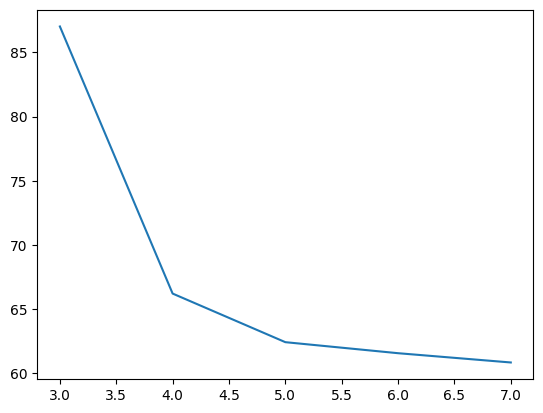

In [55]:
inertias = []
k_values = range(3,8)
for k in k_values:
    m_model = get_best_model(iter=10, cluster_number=k, n_clusters=k, neighbors=graph, random_seed=42)
    print(m_model.inertia)
    inertias.append(m_model.inertia)
plt.plot(k_values,inertias)

In [ ]:
#Printing a map
def print_map(clusters):
    gdf_copy = gdf.set_index("ID")
    gdf_copy.sort_index(inplace=True)
    
    gdf_copy['cluster']= clusters
    regions = gdf_copy.plot(column='cluster', linewidth=0.4, edgecolor='black', legend=False, categorical=True)


## 4 clusters

In [ ]:
model = KMeansWithNeighbors(n_clusters=4, neighbors=graph, random_seed=42)
clusters = model.fit_transform(df2)
print_map(clusters)
print(clusters)
print("Inertia: ", model.inertia)

## 5 Clusters

In [ ]:
model = KMeansWithNeighbors(n_clusters=5, neighbors=graph, random_seed=200)
clusters = model.fit_transform(df2)
print_map(clusters)
print(clusters)
print("Inertia: ", model.inertia)

In [ ]:
model = KMeansWithNeighbors(n_clusters=4, neighbors=graph, random_seed=42)
clusters = model.fit_transform(df2)
print(clusters)
print("Inertia: ", model.inertia)

In [74]:
map_cluster = {"Region1": [7.0, 33.0, 27.0, 41.0, 21.0, 36.0, 37.0],
"Region2": [9.0, 4.0, 6.0, 45.0, 57.0, 10.0, 20.0, 34.0, 49.0, 50.0, 12.0, 24.0, 26.0, 32.0, 47.0, 17.0, 8.0, 31.0, 5.0, 40.0, 42.0, 15.0, 30.0, 18.0, 54.0, 2.0, 3.0, 29.0, 19.0, 53.0, 56.0, 48.0, 51.0],
"Region3": [13.0, 11.0, 22.0, 14.0, 55.0, 39.0, 28.0, 16.0],
"Region4": [25.0, 52.0, 23.0, 46.0, 38.0, 43.0, 1.0, 44.0, 35.0, 14.0]}

def _compute_inertia(data,labels):
    centroids = []
    
    inertia = 0
    for i in range(4):
        points = data[labels == i]
        centroids.append(np.mean(points, axis=0))
        inertia = inertia + np.sum(np.sum((points-centroids[i])**2,axis=1))
    return inertia
    
labels_arr = np.zeros(57)
print(labels_arr)
i = 0
for key in map_cluster:
    for val in map_cluster[key]:
        labels_arr[int(val)-1] = i
    i += 1
print(labels_arr)
_compute_inertia(df2.to_numpy(), labels_arr)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[3. 1. 1. 1. 1. 1. 0. 1. 1. 1. 2. 1. 2. 3. 1. 2. 1. 1. 1. 1. 0. 2. 3. 1.
 3. 1. 0. 2. 1. 1. 1. 1. 0. 1. 3. 0. 0. 3. 2. 1. 0. 1. 3. 3. 1. 3. 1. 1.
 1. 1. 1. 3. 1. 1. 2. 1. 1.]


207.88342193622225

0
[1 3 0 3 1 0 2 0 2 2 3 0 3 3 0 3 1 0 3 0 2 3 2 1 2 2 0 3 3 1 0 2 0 0 2 0 2
 1 3 2 2 2 1 1 0 1 0 1 0 1 1 1 0 0 3 1 0]
66.19710278367717


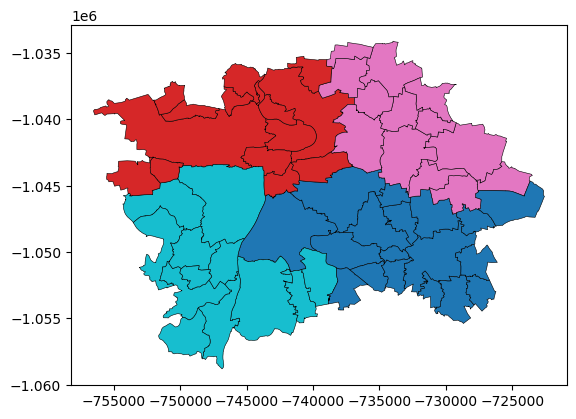

In [72]:
model = get_best_model(iter=25, cluster_number=4, n_clusters=4, neighbors=graph, random_seed=42)
print_map(model.labels)
print(model.labels)
print(model.inertia)